In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
order_products_train = pd.read_csv("data/order_products__train.csv")
order_products_prior = pd.read_csv("data/order_products__prior.csv")

# 1. "order\_products\_*.csv" Data Analysis

In [3]:
print("The order_products_prior size is : ", order_products_prior.shape)
order_products_prior.head(5)

The order_products_prior size is :  (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
print("The order_products_train size is : ", order_products_train.shape)
order_products_train.head(5)

The order_products_train size is :  (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Make order_products_all (prior+train)

In [5]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", len(order_products_all))
order_products_all.head(5)

The order_products_all size is :  33819106


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Check Unique orders and ordered products

In [6]:
# Check the number of unique orders and unique products
orders_Unique = len(order_products_all.order_id.unique())
products_Unique = len(order_products_all.product_id.unique())
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


## 1-1) Missing Data

In [7]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


    ➢ order_products_* 에는 Missing Data가 없음.

## 1-2) 한 번에 몇 개의 products를 주문하는가?

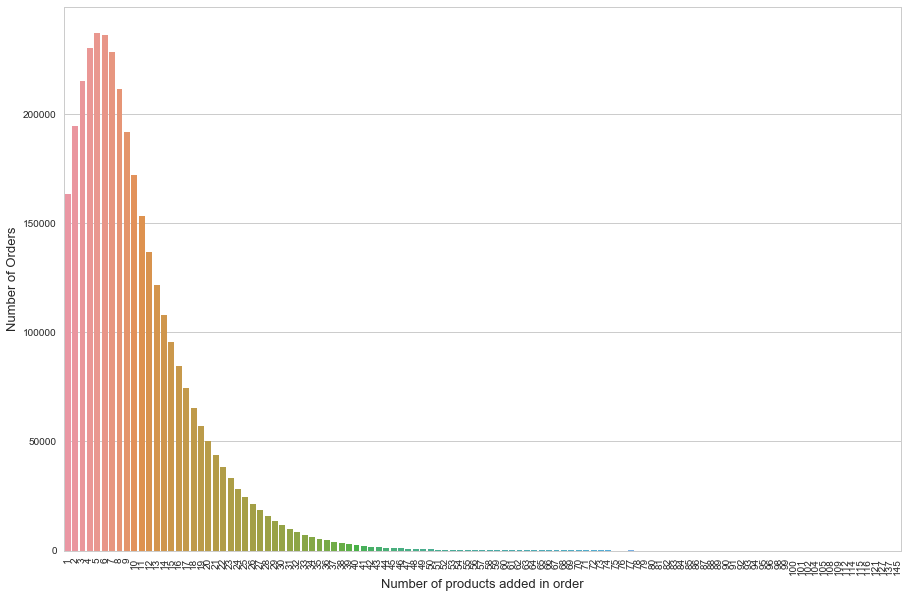

In [8]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

    ➢ 대부분 약 20개 이내의 products를 한 번에 주문함.

## 1-3) 가장 많이 팔린 제품(products)은 무엇인가?

In [9]:
grouped = pd.value_counts(order_products_all.product_id).reset_index()
grouped.columns = ['product_id', 'Total_Orders']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped.head(10)

NameError: name 'products' is not defined

In [ ]:
grouped  = grouped.groupby(['product_name']).sum()['Total_Orders'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most ordered Products', fontsize=13)
plt.show()

## 1-4) 가장 많이 재구매(reordered)를 한 제품은 무엇인가?

In [ ]:
grouped = order_products_all.groupby('product_id')['reordered'].sum().reset_index()
grouped.columns = ['product_id', 'frequency']
grouped.sort_values(by='frequency', ascending=False, inplace=True)
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped.head(10)

## 1-5) 재구매할 확률*(reorders/total_orders)*이 가장 높은 제품은 무엇인가?

In [ ]:
grouped = order_products_all.groupby("product_id")["reordered"].aggregate({'reorder_sum': sum,'order_total': 'count'}).reset_index()
grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['order_total']
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped[grouped.order_total > 100].sort_values(['reorder_probability'], ascending=False)
grouped.head(10)

In [ ]:
grouped  = grouped.groupby(['product_name']).sum()['reorder_probability'].sort_values(ascending=False)

sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(grouped.index, grouped.values)
plt.ylim([0.84,0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=13)
plt.show()

## 1-6) 첫구매 vs 재구매 비율

In [ ]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped